# Feature engineering & first models

In [1]:
# Packages
import pandas as pd 
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score
from sklearn import preprocessing 
from sklearn import metrics
import random
import warnings 
warnings.filterwarnings('ignore')

# Grain setting guarantees the reproductibility of results
np.random.seed(123) 

# Loading data
data = pd.read_csv('german_credit_data_dataset.csv')
data = pd.DataFrame(data)
data.head()

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,property,age,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,customer_type
0,A11,6,A34,A43,1169.0,A65,A75,4.0,A93,A101,...,A121,67.0,A143,A152,2.0,A173,1,A192,A201,1
1,A12,48,A32,A43,5951.0,A61,A73,2.0,A92,A101,...,A121,22.0,A143,A152,1.0,A173,1,A191,A201,2
2,A14,12,A34,A46,2096.0,A61,A74,2.0,A93,A101,...,A121,49.0,A143,A152,1.0,A172,2,A191,A201,1
3,A11,42,A32,A42,7882.0,A61,A74,2.0,A93,A103,...,A122,45.0,A143,A153,1.0,A173,2,A191,A201,1
4,A11,24,A33,A40,4870.0,A61,A73,3.0,A93,A101,...,A124,53.0,A143,A153,2.0,A173,2,A191,A201,2


## James-Stein Encoding

In [2]:
# Unlike other encoding methods (such as one-hot encoding), this method uses knowledge of the target. 
# It is important if you use this method to encode after splitting into training and testing sets. 

# Training and test sets split
# 80% of observations belong to the training set the rest to the test
X_train, X_test, Y_train, Y_test = train_test_split(data.drop('customer_type', axis=1), data['customer_type'])

In [3]:
# Selection of columns to be encoded
cols = data.select_dtypes(include = 'object').columns.values 

# Building the encoder
encoder = ce.JamesSteinEncoder(cols = cols)
print(encoder)

JamesSteinEncoder(cols=array(['checking_account_status', 'credit_history', 'purpose', 'savings',
       'present_employment', 'personal', 'other_debtors', 'property',
       'other_installment_plans', 'housing', 'job', 'telephone',
       'foreign_worker'], dtype=object),
                  drop_invariant=False, handle_missing='value',
                  handle_unknown='value', model='independent',
                  random_state=None, randomized=False, return_df=True,
                  sigma=0.05, verbose=0)


## Target encoding

In [4]:
# Building the encoder
target_encoder = ce.target_encoder.TargetEncoder(data, cols = cols)
print(target_encoder)

TargetEncoder(cols=array(['checking_account_status', 'credit_history', 'purpose', 'savings',
       'present_employment', 'personal', 'other_debtors', 'property',
       'other_installment_plans', 'housing', 'job', 'telephone',
       'foreign_worker'], dtype=object),
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=1.0,
              v...
..        ...   ...                      ...     ...              ...   ...   
995      A121  31.0                     A143    A152              1.0  A172   
996      A122  40.0                     A143    A152              1.0  A174   
997      A123  38.0                     A143    A152              1.0  A173   
998      A124  23.0                     A143    A153              1.0  A173   
999      A123  27.0                     A143    A152              1.0  A173   

    dependents  telephone foreign_worker customer_type  
0            1   

## One-Hot Encoding

In [5]:
# Building the encoder
oh_encoder = ce.one_hot.OneHotEncoder(data, cols = cols)
print(oh_encoder)

OneHotEncoder(cols=array(['checking_account_status', 'credit_history', 'purpose', 'savings',
       'present_employment', 'personal', 'other_debtors', 'property',
       'other_installment_plans', 'housing', 'job', 'telephone',
       'foreign_worker'], dtype=object),
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=False,
              verbose=    checki...
..        ...   ...                      ...     ...              ...   ...   
995      A121  31.0                     A143    A152              1.0  A172   
996      A122  40.0                     A143    A152              1.0  A174   
997      A123  38.0                     A143    A152              1.0  A173   
998      A124  23.0                     A143    A153              1.0  A173   
999      A123  27.0                     A143    A152              1.0  A173   

    dependents  telephone foreign_worker customer_type  
0            1       A192   

In [6]:
# Encoding
encoded = oh_encoder.fit_transform(data)

# Training and test sets split
# 80% of observations belong to the training set the rest to the test
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(encoded.drop('customer_type', axis=1), encoded['customer_type'])

## Random Forest for James Stein Encoding

In [7]:
# Build the model, including the encoder

model1 = Pipeline([
  ('encode_categorical', encoder),
  ('classifier', RandomForestClassifier())
])

# Exhaustive search over specified parameter values for an estimator.
param_grid = { 
    'classifier__n_estimators': [50, 100, 200, 500],# the number of trees in the forest.
    'classifier__max_features': ['sqrt', 'log2'], # the number of features to consider when looking for the 
                                                  # best split:
                                                      ## if “sqrt”, then max_features=sqrt(n_features)
                                                      ## if “log2”, then max_features=log2(n_features).
    
    'classifier__max_depth' : [4,5,6,7,8],
    'classifier__criterion' :['gini', 'entropy'] # the function to measure the quality of a split. 
                                                 # Supported criteria are “gini” for the Gini impurity 
                                                 # and “entropy” for the information gain
}

grid_search1 = GridSearchCV(model1, param_grid = param_grid, cv = 5)
grid_search1.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('encode_categorical',
                                        JamesSteinEncoder(cols=array(['checking_account_status', 'credit_history', 'purpose', 'savings',
       'present_employment', 'personal', 'other_debtors', 'property',
       'other_installment_plans', 'housing', 'job', 'telephone',
       'foreign_worker'], dtype=object),
                                                          drop_invariant=Fal...
                                                               random_state=None,
                                                               verbose=0,
                                                               warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [4, 5, 6, 7

In [8]:
grid_search1.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 50}

In [9]:
model1 = Pipeline([
  ('encode_categorical', encoder),
  ('classifier', RandomForestClassifier(n_estimators = 50, max_depth = 8, criterion = 'gini', max_features='sqrt'))
  ])

model1.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('encode_categorical',
                 JamesSteinEncoder(cols=['checking_account_status',
                                         'credit_history', 'purpose', 'savings',
                                         'present_employment', 'personal',
                                         'other_debtors', 'property',
                                         'other_installment_plans', 'housing',
                                         'job', 'telephone', 'foreign_worker'],
                                   drop_invariant=False, handle_missing='value',
                                   handle_unknown='value', model='independ...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=8, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                          

In [10]:
predict_class1 = model1.predict(X_test)
predict_proba1 = model1.predict_proba(X_test)[:, 1]

## Random forest for Target Encoding

In [11]:
model2 = Pipeline([
  ('encode_categorical', target_encoder),
  ('classifier', RandomForestClassifier())
])

grid_search2 = GridSearchCV(model2, param_grid = param_grid, cv = 5)
grid_search2.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('encode_categorical',
                                        TargetEncoder(cols=array(['checking_account_status', 'credit_history', 'purpose', 'savings',
       'present_employment', 'personal', 'other_debtors', 'property',
       'other_installment_plans', 'housing', 'job', 'telephone',
       'foreign_worker'], dtype=object),
                                                      drop_invariant=False,
                                                      h...
                                                               random_state=None,
                                                               verbose=0,
                                                               warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
          

In [12]:
grid_search2.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 50}

In [13]:
model2 = Pipeline([
  ('encode_categorical', target_encoder),
  ('classifier', RandomForestClassifier(n_estimators = 200, max_depth = 8, criterion = 'gini', max_features='log2'))
  ])

model2.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('encode_categorical',
                 TargetEncoder(cols=['checking_account_status',
                                     'credit_history', 'purpose', 'savings',
                                     'present_employment', 'personal',
                                     'other_debtors', 'property',
                                     'other_installment_plans', 'housing',
                                     'job', 'telephone', 'foreign_worker'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=8, max_features='log2',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_d

In [14]:
predict_class2 = model2.predict(X_test)
predict_proba2 = model2.predict_proba(X_test)[:, 1]

## Random forest for One-Hot Encoding

In [15]:
model3 = RandomForestClassifier()

param_grid3 = { 
    'n_estimators': [50, 100, 200, 500],# the number of trees in the forest.
    'max_features': ['sqrt', 'log2'],   # the number of features to consider when looking for the 
                                                  # best split:
                                                      ## if “sqrt”, then max_features=sqrt(n_features)
                                                      ## if “log2”, then max_features=log2(n_features).
    
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']    # the function to measure the quality of a split. 
                                                 # Supported criteria are “gini” for the Gini impurity 
                                                 # and “entropy” for the information gain
}

grid_search3 = GridSearchCV(model3, param_grid=param_grid3, cv = 5)
grid_search3.fit(X_train3, Y_train3)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [22]:
grid_search3.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 50}

In [23]:
model3 = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='log2', n_estimators=500)
model3.fit(X_train3, Y_train3)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
predict_class3 = model3.predict(X_test3)
predict_proba3 = model3.predict_proba(X_test3)[:, 1]

## Zestawienie rezultatów

### Dla predykcji klasy

In [25]:
pd.DataFrame({"Encoder" : ["Target Encoding", "James Stein Encoding", "One-Hot Encoding"],
             "Precision": [precision_score(Y_test, predict_class1, average='macro'), precision_score(Y_test, predict_class2, average='macro'), precision_score(Y_test3, predict_class3, average='macro')],
             "Recall": [recall_score(Y_test, predict_class1), recall_score(Y_test, predict_class2), recall_score(Y_test3, predict_class3)]})

,Encoder,Precision,Recall
0,Target Encoding,0.731012,0.934524
1,James Stein Encoding,0.751190,0.940476
2,One-Hot Encoding,0.752131,0.971429


Text(0.5, 1.0, 'Precision-Recall curve for One-Hot Encoding')

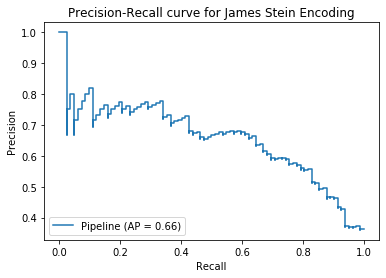

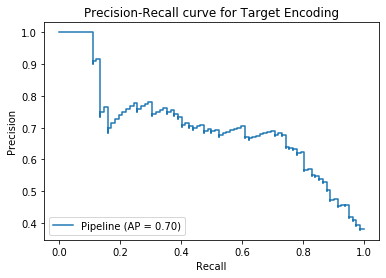

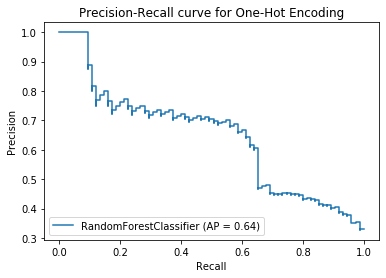

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp1 = plot_precision_recall_curve(model1, X_test, Y_test)
disp1.ax_.set_title('Precision-Recall curve for James Stein Encoding')
disp2 = plot_precision_recall_curve(model2, X_test, Y_test)
disp2.ax_.set_title('Precision-Recall curve for Target Encoding')
disp3 = plot_precision_recall_curve(model3, X_test3, Y_test3)
disp3.ax_.set_title('Precision-Recall curve for One-Hot Encoding')

### Dla predykcji prawdopodobieństwa

In [30]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(Y_test, predict_proba1, pos_label=2) # false & true positive rates
fpr2, tpr2, thresholds2 = metrics.roc_curve(Y_test, predict_proba2, pos_label=2) # false & true positive rates
fpr3, tpr3, thresholds3 = metrics.roc_curve(Y_test3, predict_proba3, pos_label=2) # false & true positive rates


pd.DataFrame({"Encoder" : ["James-Stein Encoding", "Target Encoding", "One-Hot Encoding"],
             "AUC": [metrics.auc(fpr1, tpr1), metrics.auc(fpr2, tpr2), metrics.auc(fpr3, tpr3)]})

,Encoder,AUC
0,James-Stein Encoding,0.806185
1,Target Encoding,0.833406
2,One-Hot Encoding,0.786362


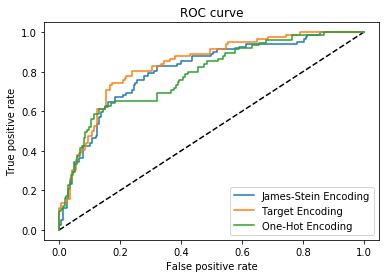

In [29]:
# ROCR curve
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='James-Stein Encoding')
plt.plot(fpr2, tpr2, label='Target Encoding')
plt.plot(fpr3, tpr3, label='One-Hot Encoding')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Jak widać dla algorytmu Random Forest najlepszą metodą kodowania zmiennych kategorycznych okazuje się Target Encoding. Różnice rezultatów względem rozważanych miar nie są jednak krytyczne. Nie mniej jednak z naszych rozważań wynika, że w ogólności Random Forest nie jest optymalnym klasyfikatorem niezależnie od metody kodowania. (patrz plik XGBoost).